## Linear least-squares and a bland dense network

We're going to use the MIT-BIH datasets to train and test a basic feedforward network and see how it does. We'll compare the results to a linear regression.

We'll use two different inputs: a mostly unprocessed version of the dataset, and a version in the frequency domain obtained by applying the FFT.

In [1]:
import datetime
import os
import logging
import numpy as np
import tensorflow as tf

import tools.plot as plot
import tools.train as train
import tools.models as models

## Read in data
files = ("../data/mitbih_train.csv", "../data/mitbih_test.csv")
inputs, labels, sparse_labels, df = train.preprocess(*files, fft=False)
inputs_fft = train.dataset_fft(inputs)
train.class_count(df)

Using TensorFlow backend.



Train set
Count of each class
Classes
0.0    72471
1.0     2223
2.0     5788
3.0      641
4.0     6431
dtype: int64

Test set
Count of each class
Classes
0.0    18118
1.0      556
2.0     1448
3.0      162
4.0     1608
dtype: int64


Let's look at a few random samples of the training data:

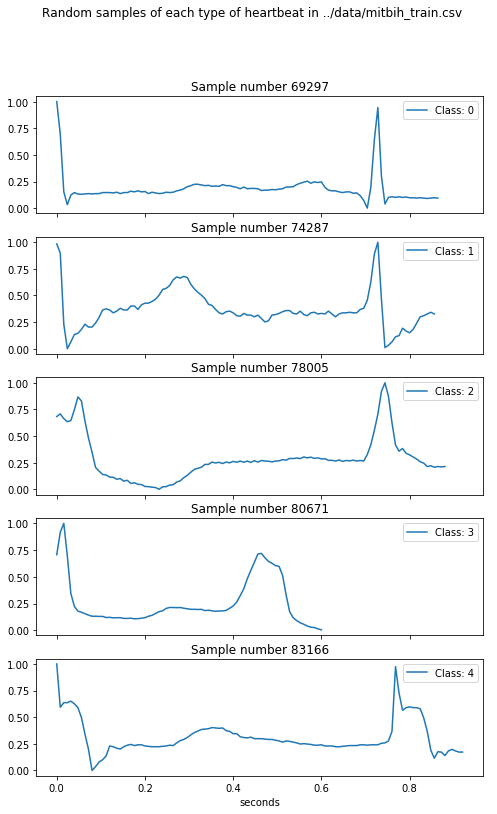

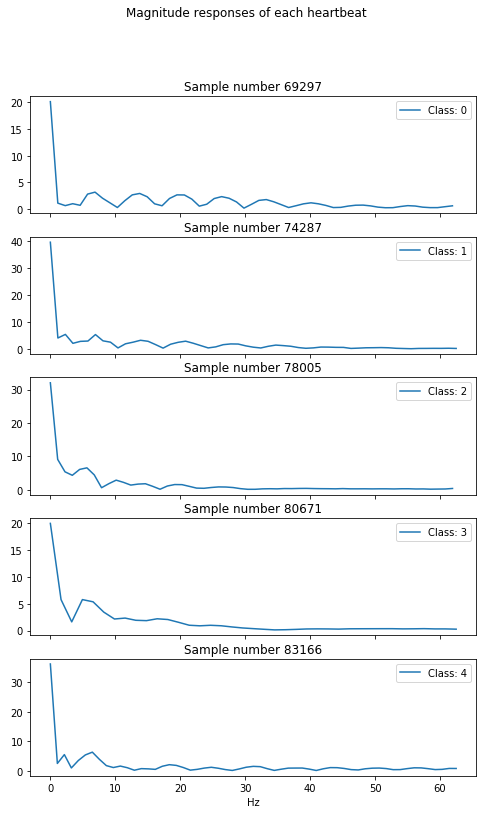

In [2]:
plot.plot_ecg(files[0], 125, 1)

### Least-squares
Let's try least-squares regression with numpy.

In [3]:
lstsq_soln = np.linalg.lstsq(inputs["train"], labels["train"], rcond=None)
lstsq_soln_fft = np.linalg.lstsq(inputs_fft["train"], labels["train"], rcond=None)
print("Rank of training dataset:", lstsq_soln[2])
print("Rank of training dataset after (real) FFT:", lstsq_soln_fft[2])

Rank of training dataset: 187
Rank of training dataset after (real) FFT: 94


Now let's see how accurate it is.

Regular least-squares
Training accuracy: 0.8948306188181008
Test accuracy: 0.8952128631463548
Confusion matrix, without normalization
[[17916     3   149     0    50]
 [  496    30    27     0     3]
 [ 1047    20   320     0    61]
 [  155     0     7     0     0]
 [  271     0     5     0  1332]]


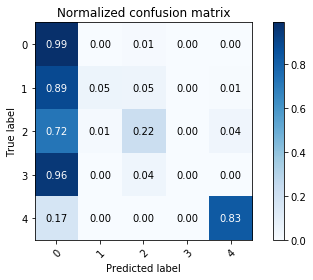

In [4]:
def lstsq_accuracy(inputs, labels, coeffs):
    
    predict = {}
    accuracy = {}
    for key in inputs:
        predict[key] = np.argmax(np.dot(inputs[key], coeffs), axis=1)
        num_correct = np.sum(
            labels[key][range(labels[key].shape[0]), predict[key]] == 1
        )
        accuracy[key] = num_correct / labels[key].shape[0]
    print("Training accuracy:", accuracy["train"])
    print("Test accuracy:", accuracy["test"])
    
    return predict

print("Regular least-squares")
predict = lstsq_accuracy(inputs, labels, lstsq_soln[0])
plot.plot_cm(sparse_labels["test"], predict["test"], classes=np.arange(5), normalize=True)

After FFT
Training accuracy: 0.9001073623135436
Test accuracy: 0.8965375479627261
Confusion matrix, without normalization
[[17956     0    80     0    82]
 [  509    12     8     0    27]
 [  963     0   415     0    70]
 [  158     0     4     0     0]
 [  341     0    23     0  1244]]


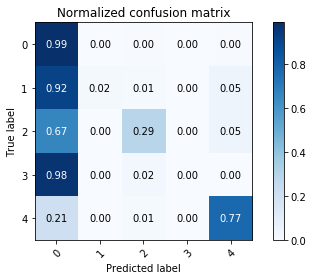

In [5]:
print("After FFT")
predict_fft = lstsq_accuracy(inputs_fft, labels, lstsq_soln_fft[0])
plot.plot_cm(sparse_labels["test"], predict_fft["test"], classes=np.arange(5), normalize=True)

### Dense feed-forward network
Let's try an unregularized, bland feed-forward network with a couple of hidden layers.

Unprocessed data
Model: "dense_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 187)]             0         
_________________________________________________________________
dense (Dense)                (None, 100)               18800     
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 505       
Total params: 19,305
Trainable params: 19,305
Non-trainable params: 0
_________________________________________________________________

Training
Train acc: 0.9854033
Test acc: 0.97642976


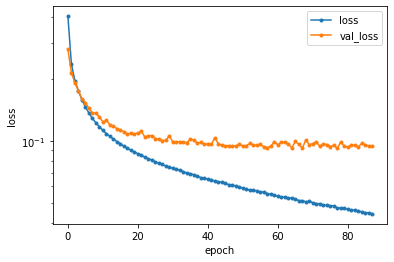

Confusion matrix, without normalization
[[18006    52    40     5    15]
 [  174   367    13     0     2]
 [   84     3  1343    10     8]
 [   37     0    24   100     1]
 [   36     4     8     0  1560]]


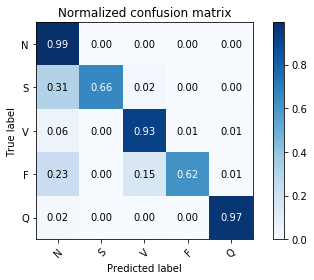

In [6]:
# Tensorboard logging
rightnow = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
nofftpath = os.path.join("..", "logs", rightnow, "nofft")

config = {
    "optimizer": "Nadam",
    "loss": "categorical_crossentropy",
    "batch_size": 200,
    "val_split": 0.05,
    "epochs": 300,
    "verbose": 0,
    "patience": 20,
    "logdir": nofftpath,
}

inputsize = inputs["train"].shape[1]
ncategories = labels["train"].shape[1]
hiddenlayers = [(100, "relu")]

# Suppress tensorflow warnings about internal deprecations
logger = tf.get_logger()
logger.setLevel(logging.ERROR)

print("Unprocessed data")
model = models.create_dense(inputsize, hiddenlayers, ncategories)
history = train.train_print(model, inputs, labels, config)
plot.plot_fit_history(history)
test_pred = np.argmax(model.predict(inputs["test"]), axis=1)
plot.plot_cm(
    sparse_labels["test"],
    test_pred,
    classes=np.array(["N", "S", "V", "F", "Q"]),
    normalize=True,
)

After FFT
Model: "dense_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 94)]              0         
_________________________________________________________________
dense_2 (Dense)              (None, 100)               9500      
_________________________________________________________________
dense_3 (Dense)              (None, 5)                 505       
Total params: 10,005
Trainable params: 10,005
Non-trainable params: 0
_________________________________________________________________

Training
Train acc: 0.97610617
Test acc: 0.9665631


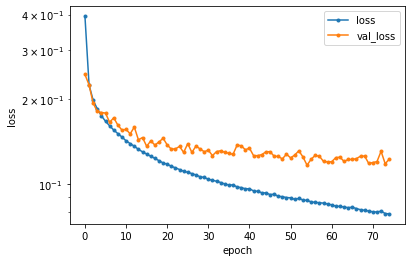

Confusion matrix, without normalization
[[17941    46    91     7    33]
 [  187   353    14     0     2]
 [  154    11  1248    22    13]
 [   50     2    12    98     0]
 [   67     0    21     0  1520]]


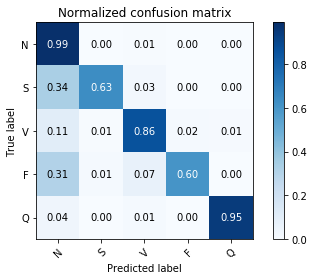

In [7]:
# Tensorboard logging
fftpath = os.path.join("..", "logs", rightnow, "fft")
config_fft = config
config_fft["logdir"] = fftpath

print("After FFT")
model_fft = models.create_dense(inputs_fft["train"].shape[1], hiddenlayers, ncategories)
history_fft = train.train_print(model_fft, inputs_fft, labels, config_fft)
plot.plot_fit_history(history_fft)

test_pred_fft = np.argmax(model_fft.predict(inputs_fft["test"]), axis=1)
plot.plot_cm(
    sparse_labels["test"],
    test_pred_fft,
    classes=np.array(["N", "S", "V", "F", "Q"]),
    normalize=True,
)

The results don't tend to be very consistent. The final test accuracy varies from run to run generally fairly significantly and it's not clear if the FFT "does" anything for the accuracy of the training.